# Creating Heatmaps from Sequencing Data

In [57]:
import pandas as pd
import numpy as np
import subprocess, os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans

## Creating a list of Consensus Sequences

With RNA-seq Heatmaps, each row represents a gene, making alignment of RNA-seq data to a heatmap relatively straightforward. However, with other sequencing experiments such as ATAC-seq, there are no such strict boundaries on what constitutes the rows of the heatmap. From my experience, creating a list of consensus sequences across all samples is the most efficient way to create rows.

While there are no doubt many ways to go about creating this list, the most straightforward method that I have found is to use bedtools and a custom python script to find all regions of overlap, and save the read counts as a matrix.

### Let's get some data to play with!

I am going to download [liver](https://www.encodeproject.org/experiments/ENCSR785NEL/) and [brain](https://www.encodeproject.org/experiments/ENCSR273UFV/) BAM files from ENCODE to use as tutorial data. BAM peaks will then be called so I can get the genomic loci for each file and the read counts at each loci. There are a variety of different programs which call peaks, so use whichever method works best for you. Here are some other methods which you can use:

* [Genrich](https://github.com/jsh58/Genrich)
* [MACS2](https://github.com/taoliu/MACS)
* [HOMER](http://homer.ucsd.edu/homer/ngs/peaks.html)
* [HMMRATAC](https://github.com/LiuLabUB/HMMRATAC)

Genrich and MACS2 are the current standards, though Genrich has not been published yet. I will be using Genrich in this tutorial, but Galaxy also has a great [tutorial](https://galaxyproject.github.io/training-material/topics/epigenetics/tutorials/atac-seq/tutorial.html#peak-calling) on MACS2 if you want to use that instead.

In [2]:
def run_genrich(bam,outpath,path=0):
    # given some bam, run genrich and send narrowPeak and bed output to output
    # path to genrich script can be specified. Otherwise, will assume that `Genrich` is the path
    
    # will run the following terminal command: Genrich -t bam -o outnarrow -b outbed -r -v
    
    if '/' in bam:
        header = bam.split('/')[-1].split('.bam')[0]
    elif '.bam' in bam:
        header = bam.split('.bam')[0]
    else:
        print("ERROR, please use a valid BAM file")
    if outpath[-1] != '/':
        outpath += '/'
        
    outnarrow = outpath + header + '.narrowPeak'
    outbed = outpath + header + '.bed'
    if path == 0:
        path = 'Genrich'
        
    subprocess.run(path+ ' -t ' + bam + ' -o ' + outnarrow + " -b " + outbed + " -r -v",shell=True,check=True)

In [ ]:
bamdir = '/mnt/labshare/chromatin-datasets/'
filenames = ['liver-p1.sorted.bam', 'liver-p2.sorted.bam','brain-p1.sorted.bam','brain-p2.sorted.bam']

# I have my bam files stored in the directory `/mnt/labshare/chromatin-datasets/`
# For the specified filenames in said directory, run genrich

for i in os.listdir(bamdir):
    if i in filenames:
        run_genrich(bamdir+i,".",'Genrich')

Now we have our peak sequences!

Once we have our files, we can work on decreasing the size of our giant bed files. The best way to do this is to use `bedtools merge`.

example:

`sort -k 1,1 -k2,2n liver-p1.bed | bedtools merge > liver-p1.merged.bed`

Now we have our merged files. Lets combine them all, sort them, then merge them again so that we get our consensus sequences. 

`cat *.merged.bed | sort -k 1,1 -k2,2n | bedtools merge > consensus.bed`

Congrats, we have our consensus sequence! However, we still need readcounts per sample for each of these loci. We can use bedtools coverage to get that data.

ex: `bedtools coverage -a consensus.bed -b liver-p1.sorted.bam -counts -sorted > liver-p1.reads.bed`

### What files do we have now?

Ok, that was a lot. Lets review what files we have created so far.

1. We have bam files for every sample and experiment.
2. We have bed files and narrowPeak files for the peak calls in those experiments.
3. We have merged bed files per sample per experiment.
4. We have a consensus bed sequence.
5. We have bed files for every sample/experiment with readcounts for each consensus sequence

For the creation of our heatmap, and for general DE analysis, we only need the bed file wiht read counts (5) going forward.

## Creating a read count matrix

Now that we have our consensus bed sequences, we can use it to create a matrix of read counts per loci for each sample. You can run the below code to create your matrix.

In [13]:
def create_matrix(beddir,headerspec=0):
    
    """
    Take in some directory of bed files, and output a df of readcounts per loci, assuming
    each has the same loci. headerspec can be used to specify what files to analyze
    """
    
    header = []
    files = []
    
    if beddir[-1] != '/':
        beddir += '/'
    for i in os.listdir(beddir):
        if headerspec == 0:
            if '.bed' in i:
                files.append(beddir+i)
                header.append(i.split('.bed')[0])
        else:
            if '.bed' in i and headerspec in i:
                files.append(beddir+i)
                header.append(i.split('.bed')[0])
    
    matrixrc = {}
    
    for i in range(len(files)):
        name = files[i]
        bed = pd.read_table(name,header=None)
        if i == 0:
            loci = np.array(bed[0])+":"+np.array(bed[1].astype(str))+'-'+np.array(bed[2].astype(str))
            matrixrc['loci'] = list(loci)
        matrixrc[header[i]] = bed[3].to_list()
    matrix = pd.DataFrame(matrixrc)
    matrix = matrix.set_index('loci')
    return(matrix)

In [ ]:
rctable = create_matrix('.','reads')

In [5]:
rctable

,brain-p1.reads,liver-p2.reads,liver-p1.reads,brain-p2.reads
loci,,,,
chr1:3000147-3000296,0,2,0,0
chr1:3001734-3001776,2,0,0,0
chr1:3003137-3015174,390,310,132,370
chr1:3020240-3022071,12,14,6,8
chr1:3025892-3026349,0,2,0,0
...,...,...,...,...
chrY_JH584301_random:145257-145623,0,2,0,0
chrY_JH584301_random:206922-208298,0,2,0,0
chrY_JH584301_random:233398-233445,0,0,0,2


Nice, we have our table now! Taking a quick glance at it, it seems that some regions might be real, and some might be unimportant (how important could sequences with only 2 reads be among all the samples). 

Here we can play around with different thresholds to use to rows from our tables which aren't important. Whichever output after filtering you choose should be used in any downstream DE analysis. You can also find the CPM values per column, and use those for your filtering. But for heatmaps at least, the filtering step isn't as crucial.

In [4]:
def threshold_readcounts(df,j,n):
    """
    take in a dataframe of sequence read counts, and output a dataframe of 
    reads with at least j reads in at least n samples
    """
    threshreadcounts = {}
    loci = []
    for i in df.columns.to_list():
        threshreadcounts[i] = []
    for index,row in df.iterrows():
        atleast = 0
        for t in row.to_list():
            if type(t) != str:
                if t >= j:
                    atleast += 1
            if atleast >= n:
                loci.append(index)
                for s in range(len(list(threshreadcounts.keys()))):
                    threshreadcounts[list(threshreadcounts.keys())[s]].append(row[s])
                break
    threshreadcounts['loci'] = loci
    data = pd.DataFrame.from_dict(threshreadcounts)
    data = data.set_index('loci')
    return(data)

In [47]:
less_stringent = threshold_readcounts(rctable,4,2)

In [48]:
more_stringent = threshold_readcounts(rctable,8,2)

In [49]:
very_stringent = threshold_readcounts(rctable,14,2)

## Normalization

Now that we have our filtered data, we can normalize it. There are a variety of different ways to normalize sequencing data, and many different packages contain implementations of these different algorithms, such as edgeR and DeSeq2. Unfortunately, these algorithms have only been implemented in R. For a tutorial on using these packages to normalize data, check out this [blog](https://davetang.org/muse/2011/01/24/normalisation-methods-for-dge-data/). 

Below is my own python implementation of the normalization method TMM, adapted from these papers [Robinson and Oshlack](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2864565/#S1) and [Maza](https://doi.org/10.3389/fgene.2016.00164), as well as the edgeR source code.

In [6]:
def TMM_norm(df,mtrim=30,atrim=5,a_thresh=-1e10):
    """
    Take in some numerical matrix with indicated column names for each group in a list, and output a TMM normalized
    matrix
    """
    # pre-normalization
    non_norm = df.copy().replace(0,np.nan).dropna()
    n = non_norm.sum()
    norm = non_norm.copy() / n

    # identify reference sample
    dist = []
    quarts = norm.describe()
    mn = quarts.loc['75%'].mean()
    for i in norm.columns:
        dist.append(abs(quarts[i].loc['75%'] - mn))
    refname = norm.columns[dist.index(min(dist))]
    
    # calculation and trimming of M and A values
    
    def find_thresholds(array,val):
        # return a lower val and upper val corresponding to val percentile and 100-val percentile of array
        return([np.percentile(array,val),np.percentile(array,100-val)])
    
    rsf = []
    lognorm = np.log2(norm.copy())
    for i in lognorm.columns:
        
        #select only a single sample and reference for analysis
        log_y=lognorm[i]
        log_y_ref=lognorm[refname]
        x = non_norm[i]
        x_ref = non_norm[refname]

        # calculate m values, and threshold them
        m = log_y-log_y_ref
        m_thresholds = find_thresholds(m,mtrim)
        mlower = m_thresholds[0]
        mupper = m_thresholds[1]
        m_trimmed = m[(m >= mlower) & (m <= mupper)]
        
        # calculate a values, and threshold valid values
        a = .5*(log_y + log_y_ref)
        a = a[a >= a_thresh]
        a_thresholds = find_thresholds(a,atrim)
        alower = a_thresholds[0]
        aupper = a_thresholds[1]
        a_trimmed = a[(a >= alower) & (a <= aupper)]
        
        # find all non-trimmed genes
        trims = np.intersect1d(a_trimmed.index,m_trimmed.index)
        
        # trim data
        log_y_trim = log_y.loc[trims]
        log_y_reftrim = log_y_ref.loc[trims]
        x_trim = x.loc[trims]
        x_reftrim = x_ref.loc[trims]
        
        # get readcount sums per column
        x_sum = n[i]
        x_refsum = n[refname]
        
        # weighted means
        avariances = (((x_sum - x)/(x_sum*x)) + ((x_refsum - x_ref)/(x_refsum*x_ref))).loc[trims]
        rsf.append(2**((sum(m.loc[trims]/avariances))/sum(1/avariances)))

    # adjusting sizes to multiply to 1:
    geo_mean = np.exp(np.mean(np.log(rsf)))
    rsf_to1 = np.array(rsf)/geo_mean
    
    # adjust for library size:
    els = rsf_to1*n.values

    # normalization and cpm:
    TMM = (df / els)*1e6
    
    return(TMM)

In [7]:
TMM = TMM_norm(less_stringent)

## Feature Scaling

Now that we have our normalized data, we need to scale the data to make a heatmap. Normalizing the data corrects for a variety of factors which could prevent the raw read counts from equaling number of transcripts (RNA-seq), binding sites (CHIP-seq), or open chormatin regions (ATAC-seq), such as length of transcript/dna, total number of reads per column, and genes/loci sequenced in some samples but not others. Scaling allows us to compare these samples together directly, row-by-row, which is what we want in a heatmap, as directly puts each cell in a row into relation with each other.

There are a variety of methods to scale data:

* min-max normalization
* mean normalization
* standardization
* scaling to unit length

Below are functions implementing all of these. We can explore how each of them looks with our data!

In [8]:
def zscore(x):
    return((x.mean()-x)/x.std())

def min_max(x):
    return((x-min(x))/(max(x)-min(x)))

def mean_normalization(x):
    return((x-x.mean())/(max(x)-min(x)))

def scale_to_unit(x):
    return(x/ ((x**2).sum()**0.5))

In [9]:
TMM_stand = TMM.apply(zscore,axis=1)

In [53]:
TMM_mm = TMM.apply(min_max,axis=1)
TMM_mn = TMM.apply(mean_normalization,axis=1)
TMM_su = TMM.apply(scale_to_unit,axis=1)

## Plotting our heatmaps!

Now we can finally make some heatmaps. Seaborn has a function to create clustered heatmaps, similar to pheatmap or complexheatmap in R. However, seaborn's clustermap unfortunately is only capable of computing hierarchical clustering, which performs poorly against large datasets. This also means by default it is unable to cluster based on other algorithms such as kmeans. 

To circumnavigate this problem, we can use the kmeans implementation in sci-kit to re-order the rows of our heatmap into a properly clustered heatmap. **Note that if you use the default column clustering in clustermap, it will be different than the row clustering algorithm**

In [10]:
def cluster_n_sort(x,n):
    # Take in a dataframe, calculate kmeans, and sort
    kmeans = KMeans(n_clusters=n).fit(x)
    labels = kmeans.labels_
    clust = x.copy()
    clust['cluster'] = labels
    clust = clust.sort_values(by=['cluster'])
    clust = clust.drop(columns=['cluster'])
    return(clust)

In [11]:
tmmclust = cluster_n_sort(TMM_stand,4)

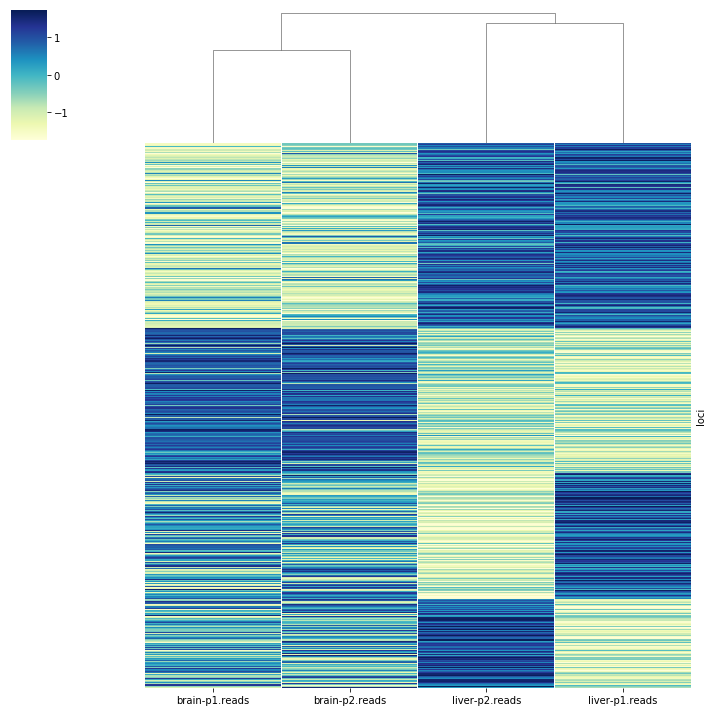

In [12]:
sns.clustermap(tmmclust,row_cluster=False,cmap='YlGnBu',yticklabels=False)

Congrats we have a heatmap! In our example data, it looks like the brain samples are very similar, and the liver samples are more similar to each other than to the brain samples, but still not super similar to each other. This suggests that there are more differences between the liver samples, which could reflect the differences in the tissue type or how the ATAC-seq was conducted. 

If you are curious about some of the decisions we made in this tutorial, continue reading where we compare some of our decisions with other options we could've made.

## What scaling algorithm should we use?

Let's explore all of our scaling options

In [54]:
tmmclust_mm = cluster_n_sort(TMM_mm,4)
tmmclust_mn = cluster_n_sort(TMM_mn,4)
tmmclust_su = cluster_n_sort(TMM_su,4)

Text(0.5, 1, 'Scale to Unit')

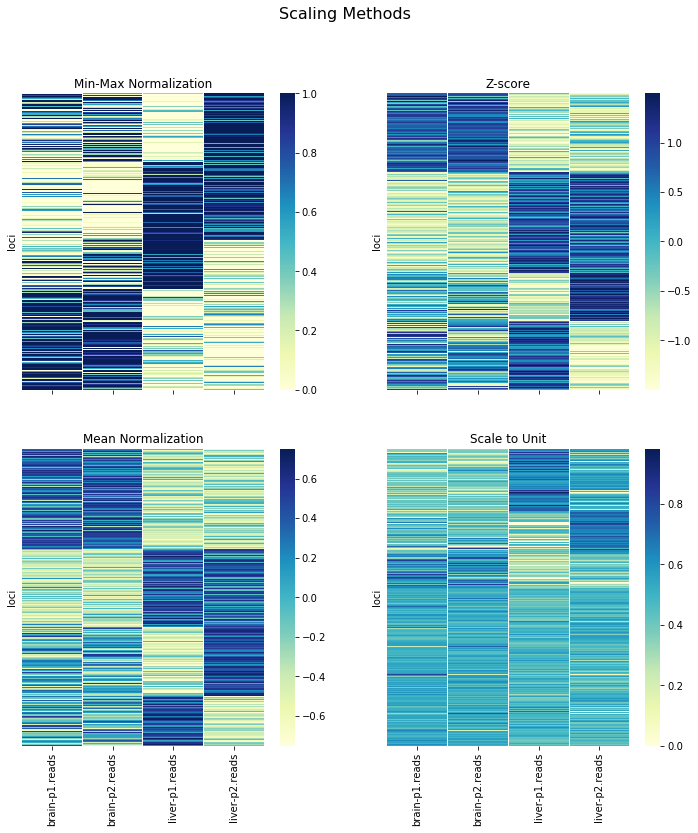

In [56]:
f, axes = plt.subplots(2, 2,figsize=(12,12),sharex=True)
f.suptitle("Scaling Methods", fontsize=16)
sns.heatmap(tmmclust_mm,cmap="YlGnBu",ax=axes[0,0],yticklabels=False)
axes[0,0].set_title("Min-Max Normalization")
sns.heatmap(tmmclust,cmap="YlGnBu",ax=axes[0,1],yticklabels=False)
axes[0,1].set_title("Z-score")
sns.heatmap(tmmclust_mn,cmap="YlGnBu",ax=axes[1,0],yticklabels=False)
axes[1,0].set_title("Mean Normalization")
sns.heatmap(tmmclust_su,cmap="YlGnBu",ax=axes[1,1],yticklabels=False)
axes[1,1].set_title("Scale to Unit")

Min-max and Scaling to Unit both by default create values from [0,1]. Mean normalization will create values from [-1,1], and standardizing will create values depending on the variance of rows.

As we can see, Scaling to Unit produces columns that look very similar to each other. With scaling to unit, values which are almost as big or as big as the vector length of that row become dark blue, values around half as big as the length are turquoise, and values less than half are yellow. However, with this dataset, most cells are of similar values across rows, meaning most of the columns are turquoise.

Min-Max on the other hand seems to produce very stark contrasts with few values in-between. It works by subtracting each value in a row by the minimum value in the row, then dividing this value by the range of the row. Since there are generally two groups in our data (liver and brain), and we would expect each of the replicates in these groups to be most similar to each other, and most different from replicates in the other samples. This means we generally only see two colors for each group, the light colored group with the minimum value of the row and the dark colored group with the maximum value. While there are some rows where these group differences stray from what we would expect, overall less total information per row is conveyed using this method.

Min-Max and Scaling to Unit both relies on using data with hard minimum and maximum boundaries. While with read counts we do have a minimum value (we can't have less than 0 reads), there is no maximum number of reads. So, you should avoid using these scaling methods while making heatmaps.

Z-scores and mean normalization produce similar results, which makes sense because they are both calculated in a very similar way (mean normalization takes the difference between a cell and row mean, and divides it by the row range, while standardization divides the difference by the standard deviation of the row). Let's look closer at these two and see what differences exist.

Text(469.23636363636354, 0.5, 'Loci (z)')

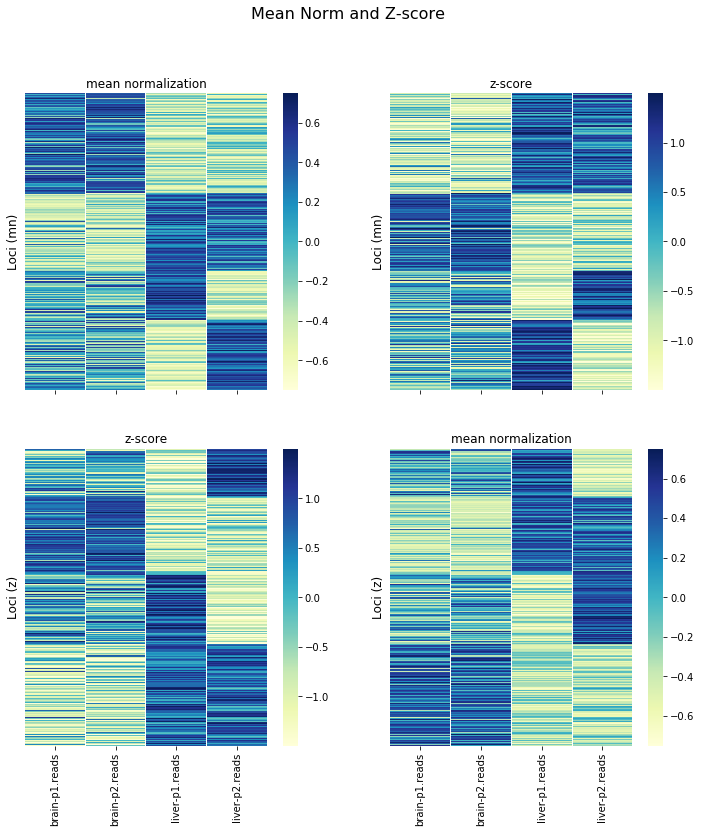

In [12]:
f, axes = plt.subplots(2, 2,figsize=(12,12),sharex=True)
f.suptitle("Mean Norm and Z-score", fontsize=16)
sns.heatmap(tmmclust_mn,cmap="YlGnBu",ax=axes[0,0],yticklabels=False)
axes[0,0].set_title("mean normalization")
sns.heatmap(tmmclust.reindex(tmmclust_mn.index),cmap="YlGnBu",ax=axes[0,1],yticklabels=False)
axes[0,1].set_title("z-score")
axes[0,0].set_ylabel('Loci (mn)', rotation=90, size='large')
axes[0,1].set_ylabel('Loci (mn)', rotation=90, size='large')
sns.heatmap(tmmclust,cmap="YlGnBu",ax=axes[1,0],yticklabels=False)
axes[1,0].set_title("z-score")
sns.heatmap(tmmclust_mn.reindex(tmmclust.index),cmap="YlGnBu",ax=axes[1,1],yticklabels=False)
axes[1,1].set_title("mean normalization")
axes[1,0].set_ylabel('Loci (z)', rotation=90, size='large')
axes[1,1].set_ylabel('Loci (z)', rotation=90, size='large')

In the above figure, Row 1 represents mean normalized and z-score heatmaps with rows aligned to the mean normalized heatmaps. Row 2 has the same heatmaps, with rows aligned to the z-score heatmap. As we can see, the data is almost identical, as it should be! This means differences between heatmaps are more subtle, and related to how the data is clustered together instead large differences in the scaled numbers computed per row. 

So which method should you use? Though both are reasonable, z-scores are much more popular than mean normalized data, and some consider it to be more robust to divide by the standard deviation than the range. If you are doing differentel expression analysis also, regardless of what method you choose, it would be best to make sure these heatmaps cluster properly with your differential analysis. 

## How much should we filter our data?

Earlier, we filtered our data to exclude regions with little to no reads, but how much should we filter? 

In [19]:
tmmm = TMM_norm(more_stringent)
tmmv = TMM_norm(very_stringent)

In [20]:
tmmm_stand = tmmm.apply(zscore,axis=1)
tmmv_stand = tmmv.apply(zscore,axis=1)

In [21]:
tmmm_cluster = cluster_n_sort(tmmm_stand,4)
tmmv_cluster = cluster_n_sort(tmmv_stand,4)

Text(0.5, 1, 'At least 2 with at least 14')

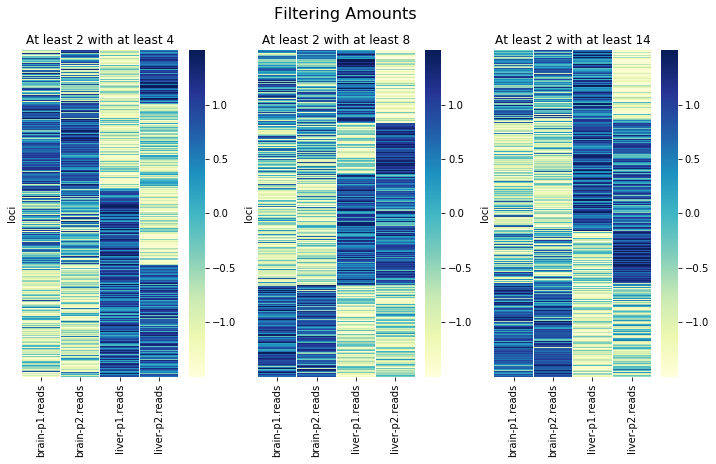

In [27]:
f, axes = plt.subplots(1, 3,figsize=(12,6))
f.suptitle("Filtering Amounts", fontsize=16)
sns.heatmap(tmmclust,cmap="YlGnBu",ax=axes[0],yticklabels=False)
axes[0].set_title("At least 2 with at least 4")
sns.heatmap(tmmm_cluster,cmap="YlGnBu",ax=axes[1],yticklabels=False)
axes[1].set_title("At least 2 with at least 8")
sns.heatmap(tmmv_cluster,cmap="YlGnBu",ax=axes[2],yticklabels=False)
axes[2].set_title("At least 2 with at least 14")

From an initial glance, heatmap variability is impacted by the filtering step, but there is no clear right choice visually. They all convey reasonable data, and fit our hypothesis that brain columns should be more similar to each other and liver columns should be more similar. Filtering becomes much more important while conducting DE analysis, so I would recommend using whichever filtering method your DE pipeline recommends before constructing your heatmaps.

## Conclusion

Congrats, you're now a heatmap pro! Note there is still a lot of subjectiveness with choosing filtering thresholds, choosing what algorithm to normalize data with, selecting a scaling algorithm, and choosing how to cluster your data, but I hope to address differences in these approaches in a future write-up.

Following these steps helped me while learning how to create heatmaps for ATAC and CHIP data, and I hope it'll help you with your work also! 